# Skater Regression

### This notebook shows the use of the Skater Regression funcion (Skater_reg), introduced by Anselin & Amaral (2021). For more information on the method, check:
https://www.researchgate.net/publication/353411566_Endogenous_Spatial_Regimes

In this example, in addition to the required packages, we will use geopandas to load the data and matplotlib to plot the results. Alternatively, PySAL's own IO could also be used to load the data.

In [1]:
# Required imports
import libpysal as ps
import numpy as np
import spreg
from spreg.skater_reg import Skater_reg

# Optional imports
import matplotlib.pyplot as plt
import geopandas as gpd

We use Messner et al. (2000) data on homicides and selected socio-economic characteristics for continental U.S. counties to exemplify the use of Skater_reg. It can be downloaded from PySAL's examples repository.

In [2]:
# Load the example from PySAL
ps.examples.load_example("NCOVR")
data = gpd.read_file(ps.examples.get_path('NAT.shp')).set_index('FIPS')

# Set depedent and independent variables and the W matrix.
y = data['HR90'].to_numpy()
x = data[['RD90','PS90','UE90']].to_numpy()
w = ps.weights.Queen.from_dataframe(data, use_index=True)

Skater_reg by default uses Euclidean distance to compute the Minimum Spanning Tree (MST). Therefore, we standardize the variables that will be used to compute the MST before calling the main Skater_reg function. Here, we use the X variables to compute the MST. Alternative specifications can be used.

We set the number of clusters to 20 and minimum quorum to 100.

In [3]:
%%time
# Standardize the variables to be used to compute the minimum spanning tree (could add/remove any variable)
x_std = (x - np.mean(x,axis=0)) / np.std(x,axis=0)

# Call the Skater_reg method based on OLS
results = Skater_reg().fit(20, w, x_std, {'reg':spreg.OLS,'y':y,'x':x}, quorum=100)

CPU times: user 1min 16s, sys: 31.6 s, total: 1min 48s
Wall time: 25.3 s


The intermediate steps are stored in the attibute \_trace. We can use this information to plot the decrease in the total sum of squared residuals by number of clusters. This information can be helpful to select the number of desired clusters.

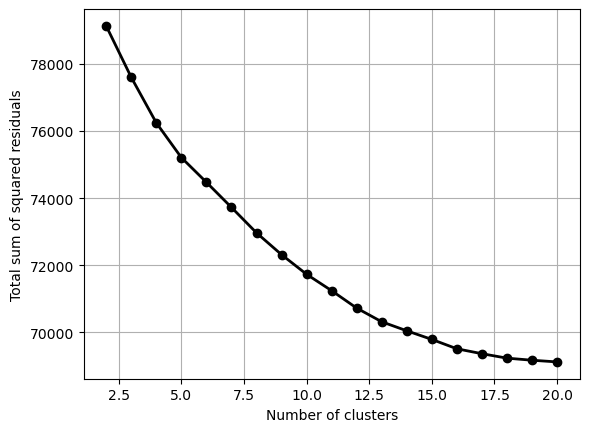

In [4]:
trace = [results._trace[i][1][2] for i in range(1,len(results._trace))]
fig, ax = plt.subplots()
ax.plot(list(range(2,len(trace)+2)), trace, '-o', color='black', linewidth=2)

ax.set(xlabel='Number of clusters', ylabel='Total sum of squared residuals')
ax.grid()

plt.show()

Let's say we choose 12 clusters. We can plot the results using geopandas and matplotlib.

(-127.6195011138916, -64.0817699432373, 23.735178565979005, 50.59252300262451)

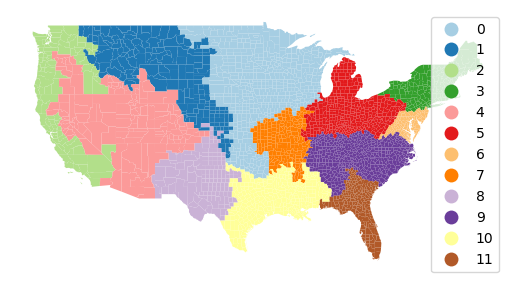

In [5]:
data["cl_regions"] = results._trace[11][0]
data.plot(column="cl_regions", categorical=True, legend=True, cmap='Paired').axis("off")

With the cluster allocations and selected number of clusters, we can call the Regimes methods in Spreg to get the full regression results and Chow tests on the stability of the coefficients accross the 12 different clusters.

In [6]:
reg = spreg.OLS_Regimes(y,x,
      regimes=results._trace[11][0], w=w, name_y=['HR90'], name_x=['RD90','PS90','UE90'], name_regimes='skater_reg')
print(reg.summary)

REGRESSION
----------

SUMMARY OF OUTPUT: ORDINARY LEAST SQUARES ESTIMATION - REGIME 0
---------------------------------------------------------------
Data set            :     unknown
Weights matrix      :     unknown
Dependent Variable  :  0_['HR90']                Number of Observations:         604
Mean dependent var  :      2.4577                Number of Variables   :           4
S.D. dependent var  :      3.9266                Degrees of Freedom    :         600
R-squared           :      0.3305
Adjusted R-squared  :      0.3271
Sum squared residual:    6224.952                F-statistic           :     98.7116
Sigma-square        :      10.375                Prob(F-statistic)     :   6.109e-52
S.E. of regression  :       3.221                Log likelihood        :   -1561.528
Sigma-square ML     :      10.306                Akaike info criterion :    3131.057
S.E of regression ML:      3.2103                Schwarz criterion     :    3148.671

--------------------------------